# Forecast emergency admissions using Deep Learning


# Introduction

__Problem:__ Public Hospitals are overwhelmed by the high number of patient admissions and emergency admissions. The goal is to predict the number of emergency admissions in the upcoming months, to help prevent bed shortage and focus resources on the hospital departments that are the most in need. 

The objectives of this project is to:
    
__Objectif 1:__ Using the information about the number of emergency admissions in the past months, forecast the number of emergency admissions in the upcoming months. 

__Objectif 2:__ Using the information about the number of emergency admissions depending on the Treatment speciality, identify which hospital departments are most likely to receive a high number of emergency admissions in the upcoming months. 

# Dataset

The dataset used in this project is the __Hospital Episodes Statistics (HES) dataset__, it consists of the record of all patients admitted to NHS (public) hospitals in England. It contains details of inpatient care such as number of admissions and number of emergency admissions, and it also contains details of outpatient appointments such as attended appointments and missed appointments. 

The records are filtered by treatment speciality, and they are produced and published monthly. The version used in this project covers the period from April 30 2018 to August 31 2021. The data is a monthly data (published on the last day of each month).

In our case, we will just use the date (__"Month_Ending"__) and the treatment speciality type (__"TRETSPEF"__) to predict the number of emergency admissions (__"EMERGENCY"__) in the future. Therefore all the columns that are in the dataset and not needed are dropped. 

The dataset can be downloaded from the [NHS Digital website](https://digital.nhs.uk/data-and-information/publications/statistical/hospital-episode-statistics-for-admitted-patient-care-outpatient-and-accident-and-emergency-data/april-2021---september-2021) 

# Import / Install Packages 

First we need to install and import the needed packages for this project. 

In [75]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#display all rows
pd.set_option('display.max_rows', None)

# Load the data

The columns that are not needed in this project have already been dropped, and the remaining columns where save as a new csv file (__Emergency_only.csv__)

In [39]:
#Load the dataset
#df_TRETSPEF = pd.read_csv('Emergency_only.csv')
df_TRETSPEF = pd.read_csv('OPEN_DATA_TREATMENT SPECIALTY.csv')
df_TRETSPEF = df_TRETSPEF.drop(['FY_Start_Date','FY_End_Date','Latest_Month_Flag','PARTYEAR'],axis=1)
df_TRETSPEF.head(5)
#df_TRETSPEF.shape

,Month_Ending,TRETSPEF,TRETSPEF_DESCRIPTION,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance
0,31OCT21,&,Not Known,196.0,35.0,173.0,23.0,19.0,163.0,37.0,6408.0,5002.0,627.0,1213.0,3789.0
1,31OCT21,100,General Surgery Service,105501.0,61406.0,68711.0,36790.0,31513.0,94058.0,49360.0,236650.0,184672.0,14018.0,72707.0,111962.0
2,31OCT21,101,Urology Service,52587.0,36730.0,25081.0,27506.0,22174.0,48692.0,11723.0,315431.0,233826.0,19276.0,68371.0,165448.0
3,31OCT21,102,Transplant Surgery Service,998.0,639.0,807.0,191.0,168.0,758.0,298.0,8990.0,6995.0,747.0,565.0,6430.0
4,31OCT21,103,Breast Surgery Service,6233.0,5407.0,2125.0,4108.0,3612.0,6135.0,150.0,156713.0,125159.0,6835.0,64099.0,61057.0


In [40]:
#check data types 
df_TRETSPEF.dtypes

Month_Ending                    object
TRETSPEF                        object
TRETSPEF_DESCRIPTION            object
FCE                            float64
FCEs_With_Procedure            float64
Ordinary_Admission_Episodes    float64
FCE_DAY_CASES                  float64
FCE_DAY_WITH_PROCEDURE         float64
FAE                            float64
EMERGENCY                      float64
Total_Appointments             float64
Attended_Appointments          float64
DNA_Appointments               float64
First_Attendance               float64
Follow_Up_Attendance           float64
dtype: object

# Preprocess the data

First we remove the rows where the treatment speciality is unkown

In [41]:
df_TRETSPEF.shape

(6705, 15)

In [42]:
#drop rows where the treatment type is unkown 
df_TRETSPEF = df_TRETSPEF[df_TRETSPEF.TRETSPEF != '&']


In [43]:
df_TRETSPEF.shape


(6662, 15)

In [44]:
df_TRETSPEF.head(5)


,Month_Ending,TRETSPEF,TRETSPEF_DESCRIPTION,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance
1,31OCT21,100,General Surgery Service,105501.0,61406.0,68711.0,36790.0,31513.0,94058.0,49360.0,236650.0,184672.0,14018.0,72707.0,111962.0
2,31OCT21,101,Urology Service,52587.0,36730.0,25081.0,27506.0,22174.0,48692.0,11723.0,315431.0,233826.0,19276.0,68371.0,165448.0
3,31OCT21,102,Transplant Surgery Service,998.0,639.0,807.0,191.0,168.0,758.0,298.0,8990.0,6995.0,747.0,565.0,6430.0
4,31OCT21,103,Breast Surgery Service,6233.0,5407.0,2125.0,4108.0,3612.0,6135.0,150.0,156713.0,125159.0,6835.0,64099.0,61057.0
5,31OCT21,104,Colorectal Surgery Service,26374.0,19625.0,8779.0,17595.0,14793.0,24132.0,3642.0,109252.0,82315.0,6476.0,38089.0,44226.0


The "Month_Ending" column which has type object, it needs to be converted to datetime.

In [45]:
#convert the Month_Ending from float to datetime
df_TRETSPEF['Month_Ending'] = pd.to_datetime(df_TRETSPEF.Month_Ending , format = None)

data = df_TRETSPEF.drop(['Month_Ending'], axis=1)
data.index = df_TRETSPEF.Month_Ending
#convert the EMERGENCY from float to int
#df_TRETSPEF.EMERGENCY = df_TRETSPEF.EMERGENCY.astype(int)


In [46]:
df_TRETSPEF.head(5)

,Month_Ending,TRETSPEF,TRETSPEF_DESCRIPTION,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance
1,2021-10-31,100,General Surgery Service,105501.0,61406.0,68711.0,36790.0,31513.0,94058.0,49360.0,236650.0,184672.0,14018.0,72707.0,111962.0
2,2021-10-31,101,Urology Service,52587.0,36730.0,25081.0,27506.0,22174.0,48692.0,11723.0,315431.0,233826.0,19276.0,68371.0,165448.0
3,2021-10-31,102,Transplant Surgery Service,998.0,639.0,807.0,191.0,168.0,758.0,298.0,8990.0,6995.0,747.0,565.0,6430.0
4,2021-10-31,103,Breast Surgery Service,6233.0,5407.0,2125.0,4108.0,3612.0,6135.0,150.0,156713.0,125159.0,6835.0,64099.0,61057.0
5,2021-10-31,104,Colorectal Surgery Service,26374.0,19625.0,8779.0,17595.0,14793.0,24132.0,3642.0,109252.0,82315.0,6476.0,38089.0,44226.0


# Split the data into training set and test set

To fit and evaluate the model, we need to split it into a training and test set. 

The problem with our dataset is that the data is not only time series data, it is considered __panel data__

__Panel Data__ (also known as __Longitudinal data__) is the data which tracks the same units at different time points.
In this case the units are the treatment specialities. 

Panel data cannot be split randomly like we would normaly do with regular cross-sectional data. Panel data needs to be split depending on each unit first, then the obtained splits are combined in to the final training set and test set. 
It is also important to take time in consideration when splitting the data, since we want to predict the future values, we want the training set to contain older samples, and the test set to contains the most recent samples (most recent values in time). 


In [47]:
#split data 
#X_train, X_test, y_train, y_test = train_test_split(df, df, test_size=0.3, shuffle=False)

In [48]:
df_TRETSPEF = df_TRETSPEF.sort_values(['Month_Ending'], ascending= True).reset_index(drop=True)


In [49]:
df_TRETSPEF.head()


,Month_Ending,TRETSPEF,TRETSPEF_DESCRIPTION,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance
0,2018-04-30,920,Diabetic Education Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.0,276.0,83.0,101.0,175.0
1,2018-04-30,259,Paediatric Nephrology,902.0,664.0,265.0,637.0,531.0,840.0,96.0,5998.0,4629.0,416.0,598.0,4031.0
2,2018-04-30,258,Paediatric Respiratory Medicine,1662.0,1148.0,1303.0,359.0,288.0,1461.0,366.0,13128.0,9097.0,1253.0,2453.0,6644.0
3,2018-04-30,257,Paediatric Dermatology,317.0,208.0,23.0,294.0,196.0,300.0,9.0,17077.0,11883.0,1486.0,3843.0,8040.0
4,2018-04-30,256,Paediatric Infectious Diseases,118.0,55.0,56.0,62.0,38.0,97.0,21.0,957.0,656.0,113.0,213.0,443.0


In [50]:
#split using time series 
tss = TimeSeriesSplit(n_splits = 5)


In [51]:
#X = df.drop(labels=['EMERGENCY'], axis=1)
X = df_TRETSPEF
#y = df['EMERGENCY']
y = pd.DataFrame(df_TRETSPEF[['Month_Ending','EMERGENCY']])
#y['Month_Ending'] = df_TRETSPEF['Month_Ending'].values

In [52]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [53]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((5552, 15), (1110, 15), (5552, 2), (1110, 2))

## Normalize the data

We need the data's values to be on the same scale before being input to the model. 

We use the scikit-learn object __MinMaxScaler__ to normalize the dataset. the advantages of using MinMaxScaler are: 
1. Fit the scaler using available training data and then apply it the training data, meaning the training data will be used to estimate the minimum and maximum observable values, and then the normalized data is used to train the model. this is done by calling the function __fit_transform()__
2. Apply the scale to data.

In [54]:
#Normalize data
#MinMaxScaler default range (0,1)
df_X_train = X_train.drop(columns=['Month_Ending','TRETSPEF','TRETSPEF_DESCRIPTION'], axis=1)
df_X_train_values = df_X_train.values
scaler = MinMaxScaler()
#df_TRETSPEF['EMERGENCY'] = scaler.fit_transform(df_TRETSPEF.drop(columns=['Month_Ending','TRETSPEF']))
#df_scaled = scaler.fit_transform(df_TRETSPEF.drop(columns=['Month_Ending','TRETSPEF','TRETSPEF_DESCRIPTION']))
df_X_train_scaled = scaler.fit_transform(df_X_train_values)
df_X_train = pd.DataFrame(df_X_train_scaled,  columns=df_X_train.columns)


In [55]:
df_X_train['Month_Ending'] = X_train['Month_Ending'].values
df_X_train['TRETSPEF'] = X_train['TRETSPEF'].values
df_X_train['TRETSPEF_DESCRIPTION'] = X_train['TRETSPEF_DESCRIPTION'].values
X_train = df_X_train


In [56]:
#df_X_test = X_test.drop(columns=['Month_Ending','TRETSPEF','TRETSPEF_DESCRIPTION'], axis=1)
#df_X_test_values = df_X_test.values
#df_X_test_scaled = scaler.fit_transform(df_X_test_values)
#df_X_test = pd.DataFrame(df_X_test_scaled,  columns=df_X_test.columns)

In [57]:
#df_X_test['Month_Ending'] = X_test['Month_Ending'].values
#df_X_test['TRETSPEF'] = X_test['TRETSPEF'].values
#df_X_test['TRETSPEF_DESCRIPTION'] = X_test['TRETSPEF_DESCRIPTION'].values
#X_test = df_X_test

In [58]:
X_train.head()

,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance,Month_Ending,TRETSPEF,TRETSPEF_DESCRIPTION
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000483,0.000373,0.001411,0.000387,0.000314,2018-04-30,920,Diabetic Education Service
1,0.002646,0.005234,0.000825,0.005354,0.004642,0.003475,0.000440,0.006240,0.006252,0.007070,0.002294,0.007233,2018-04-30,259,Paediatric Nephrology
2,0.004876,0.009050,0.004058,0.003017,0.002518,0.006044,0.001677,0.013660,0.012287,0.021294,0.009411,0.011922,2018-04-30,258,Paediatric Respiratory Medicine
3,0.000930,0.001640,0.000072,0.002471,0.001713,0.001241,0.000041,0.017769,0.016050,0.025253,0.014744,0.014427,2018-04-30,257,Paediatric Dermatology
4,0.000346,0.000434,0.000174,0.000521,0.000332,0.000401,0.000096,0.000995,0.000886,0.001920,0.000817,0.000795,2018-04-30,256,Paediatric Infectious Diseases


In [59]:
X_train=X_train.set_index(['Month_Ending'])
X_test=X_test.set_index(['Month_Ending'])
y_train=y_train.set_index(['Month_Ending'])
y_test=y_test.set_index(['Month_Ending'])

## Handling the missing values


We need to take care of the missing values, we can either:

1. Omit the entire row that contains the missing values: this will not be applied in this project, because it will make the dataset smaller. 
2. Impute or Interpolate the missing values in time series:
        - Last observation carried forward (LOCF)
        - Next observation carried backward (NOCB)
        - Linear interpolation 
        - Spline interpolation
        
In this project we use Pandas __interpolate()__ function to perform __Linear interpolation__ and fill out missing values. 


In [60]:
#x = X_train.loc[X_train['TRETSPEF'] == '656']
#x.plot(figsize=(13,5))


In [61]:
X_train = X_train.interpolate(method='linear')
X_test = X_test.interpolate(method='linear')
X_train = X_train.dropna()


# Format the data

Before feeding our data to the model, it must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences.


In [62]:
X_train.head()


,FCE,FCEs_With_Procedure,Ordinary_Admission_Episodes,FCE_DAY_CASES,FCE_DAY_WITH_PROCEDURE,FAE,EMERGENCY,Total_Appointments,Attended_Appointments,DNA_Appointments,First_Attendance,Follow_Up_Attendance,TRETSPEF,TRETSPEF_DESCRIPTION
Month_Ending,,,,,,,,,,,,,,
2018-04-30,0.002646,0.005234,0.000825,0.005354,0.004642,0.003475,0.000440,0.006240,0.006252,0.007070,0.002294,0.007233,259,Paediatric Nephrology
2018-04-30,0.004876,0.009050,0.004058,0.003017,0.002518,0.006044,0.001677,0.013660,0.012287,0.021294,0.009411,0.011922,258,Paediatric Respiratory Medicine
2018-04-30,0.000930,0.001640,0.000072,0.002471,0.001713,0.001241,0.000041,0.017769,0.016050,0.025253,0.014744,0.014427,257,Paediatric Dermatology
2018-04-30,0.000346,0.000434,0.000174,0.000521,0.000332,0.000401,0.000096,0.000995,0.000886,0.001920,0.000817,0.000795,256,Paediatric Infectious Diseases
2018-04-30,0.002675,0.002389,0.000249,0.006993,0.002369,0.003715,0.000055,0.009460,0.008066,0.011777,0.009810,0.006128,255,Paediatric Clinical Immunology and Allergy


In [63]:
X_train = X_train.drop(['TRETSPEF','TRETSPEF_DESCRIPTION','EMERGENCY'],axis=1)
X_test = X_test.drop(['TRETSPEF','TRETSPEF_DESCRIPTION','EMERGENCY'],axis=1)

#X_train = X_train.drop(['TRETSPEF','TRETSPEF_DESCRIPTION'],axis=1)
#X_test = X_test.drop(['TRETSPEF','TRETSPEF_DESCRIPTION'],axis=1)

In [64]:
def df_format(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [66]:
#format train data
X1_train, y1_train = df_format(X_train,10)
X1_train.shape, y1_train.shape

((5541, 10, 11), (5541,))

In [67]:
#format test data
X2_test, y2_test = df_format(X_test,10)
X2_test.shape, y2_test.shape

((1100, 10, 11), (1100,))

# Reshape the data 

LSTMs take inputs in a 3D format: samples, timesteps, features. We need to reshape our data in the format expected by LSTMs. 

In [68]:
#Reshape data for LSTM model 
#X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
#X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Build the model

In [62]:
del history, model


In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def build_model(train_x, train_y):
    verbose, epochs, batch_size = 1, 30, 1
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(10, 11)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse',metrics = ['accuracy'])
    train_x = np.asarray(train_x).astype('float32')
    train_y = np.asarray(train_y).astype('float32')
    history = model.fit(train_x, train_y, epochs=epochs, verbose=verbose, shuffle=False)
    return history, model



# Train the model

In [70]:
#history, model = build_model(X_train, y_train)
history, model = build_model(X1_train, y1_train)


Epoch 1/30
174/174 [==============================] - 2s 3ms/step - loss: 0.0078 - accuracy: 7.2189e-04
Epoch 2/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0067 - accuracy: 7.2189e-04
Epoch 3/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0060 - accuracy: 9.0236e-04
Epoch 4/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0058 - accuracy: 9.0236e-04
Epoch 5/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0056 - accuracy: 9.0236e-04
Epoch 6/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0055 - accuracy: 9.0236e-04
Epoch 7/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0054 - accuracy: 9.0236e-04
Epoch 8/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 9.0236e-04
Epoch 9/30
174/174 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 9.0236e-04
Epoch 10/30
174/174 [==============================] - 1s 3ms/st

# Plot the loss
The loss is decreasing over iterations

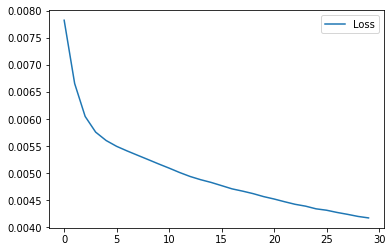

In [71]:
# plot the loss
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()


# Make predictions

Now that we have a model, we would like to be able to make predictions.

In [81]:
[test_loss,test_acc] = model.evaluate(X2_test,y2_test)
print('test accuracy: ',test_acc*100,'%')
print('test loss: ',test_loss)

In [76]:
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


In [79]:
#df_comp, mse  = plot_predictions1(model, X2_test, y2_test)


# Visualize predictions VS ground-truth

In [ ]:
plt.figure(figsize=(20,10))
pa.groupby('Month_Ending')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Month_Ending")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Emergency admissions',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Emergency admissions ',fontsize=20)
plt.legend()